In [1]:
its_jupyter_notebook = True

import sys
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
sys.path.insert(0, '..')
import ast
from tqdm.notebook import tqdm
import seaborn as sns
if its_jupyter_notebook:
    sys.argv = [''] #Remove this if it's not a jupyter notebook!

In [2]:
ROOT_DIR = os.path.dirname(os.path.abspath('.'))
processed_files_dir = os.path.join(ROOT_DIR, 'dataset', 'processed_files')
mmseq_dir = os.path.join(processed_files_dir, 'mmseq2')
os.mkdir(mmseq_dir)

In [3]:
df_cdna = pd.read_csv(os.path.join(processed_files_dir, "df_cdna.csv"), sep = ',')
df_genes = pd.read_csv(os.path.join(processed_files_dir, "df_genes.csv"), sep = ',')
df = pd.read_csv(os.path.join(processed_files_dir, "df_annotation_files_cleaned.csv"), sep = ',')

In [4]:
n_interactions = []
for _, row in df_genes.iterrows():
    gene = row.gene
    list_of_coords = ast.literal_eval(row.interaction_coords)
    n_int = len(list_of_coords) 
    n_interactions.append(n_int)
print(np.median(n_interactions))
print(np.mean(n_interactions))

2.0
4.23308962378347


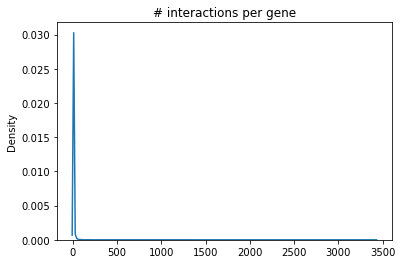

In [5]:
sns.kdeplot(n_interactions)
plt.title(f'# interactions per gene')
plt.show()

In [6]:
slice_len = 200

def obtain_cdna_slice(cdna, center_coord, seq_len = 200):
    len_cdna = len(cdna)
    x1 = max(center_coord-int(seq_len/2), 0)
    x2 = min(center_coord+int(seq_len/2), len_cdna)
    if x1 == 0:
        len_slice = x2
        scarto = seq_len-len_slice
        x2 = min(x2 + scarto, len_cdna)
    elif x2 == len_cdna:
        len_slice = x2-x1
        scarto = seq_len-len_slice
        x1 = max(x1-scarto, 0)
    return x1, x2

output_file = os.path.join(mmseq_dir, 'fasta_mmseq2.txt')

for _, row in tqdm(df.iterrows(), total=df.shape[0]):
    couple = row.couples
    gene1, gene2 = row.gene1, row.gene2
    x1, y1, x2, y2 = row.x1, row.y1, row.x1+row.w, row.y1+row.h
    cdna1 = df_cdna[df_cdna.gene_id == gene1].cdna.iloc[0]
    cdna2 = df_cdna[df_cdna.gene_id == gene2].cdna.iloc[0]
    
    slice_x1, slice_x2 = obtain_cdna_slice(cdna1, center_coord = int(np.mean([x1, x2])), seq_len = slice_len)
    slice_y1, slice_y2 = obtain_cdna_slice(cdna2, center_coord = int(np.mean([y1, y2])), seq_len = slice_len)
    
    seq1 = cdna1[slice_x1:slice_x2]
    seq2 = cdna2[slice_y1:slice_y2]

    fastafile = open(output_file, "a")
    
    list_seq = [seq1, seq2]
    list_name = [couple + ' ' + gene1, couple + ' ' + gene2]
    for i in range(len(list_seq)):
        fastafile.write(">" + list_name[i] + "\n" +list_seq[i] + "\n")
    fastafile.close()

  0%|          | 0/171281 [00:00<?, ?it/s]